# x07: Onshore LCOE w/ exclusions

In this example, we will demonstrate `Ard`'s ability to run a LCOE analysis and optimization with exclusions.

We can start by loading what we need to run the problem.

In [1]:
from pathlib import Path  # optional, for nice path specifications

import pprint as pp  # optional, for nice printing
import numpy as np  # numerics library
import matplotlib.pyplot as plt  # plotting capabilities

import ard  # technically we only really need this
from ard.utils.io import load_yaml  # we grab a yaml loader here
from ard.api import set_up_ard_model  # the secret sauce
from ard.viz.layout import plot_layout  # a plotting tool!

import openmdao.api as om  # for N2 diagrams from the OpenMDAO backend

%matplotlib inline

In [2]:
# load input
path_inputs = Path.cwd().absolute() / "inputs"
input_dict = load_yaml(path_inputs / "ard_system.yaml")

# create and setup system
prob = set_up_ard_model(input_dict=input_dict, root_data_path=path_inputs)

prob.model.set_input_defaults(
    "x_turbines",
    input_dict["modeling_options"]["windIO_plant"]["wind_farm"]["layouts"][
        "coordinates"
    ]["x"],
    units="m",
)
prob.model.set_input_defaults(
    "y_turbines",
    input_dict["modeling_options"]["windIO_plant"]["wind_farm"]["layouts"][
        "coordinates"
    ]["y"],
    units="m",
)

Adding top_level
Adding aepFLORIS
Adding boundary
Adding exclusions
Adding collection
Adding spacing_constraint
Adding tcc
Adding landbosse
Adding opex
Adding financese


/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/core/group.py:368: PromotionWarning:<model> <class Group>: Setting input defaults for input 'x_turbines' which override previously set defaults for ['auto', 'prom', 'units'].
/Users/cfrontin/miniforge3/envs/ard-dev-env/lib/python3.12/site-packages/openmdao/core/group.py:368: PromotionWarning:<model> <class Group>: Setting input defaults for input 'y_turbines' which override previously set defaults for ['auto', 'prom', 'units'].


In [3]:
if False:
    # visualize model
    om.n2(prob)

In [4]:
# run the model
prob.run_model()

# collapse the test result data
test_data = {
    "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
    "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
    "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
    "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
    "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
    "coll_length": float(prob.get_val("collection.total_length_cables", units="km")[0]),
    "turbine_spacing": float(
        np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
    ),
}

print("\n\nRESULTS:\n")
pp.pprint(test_data)
print("\n\n")



RESULTS:

{'AEP_val': 122.7865872459762,
 'BOS_val': 17.92663778128289,
 'CapEx_val': 30.939999999999998,
 'LCOE_val': 38.37713824683762,
 'OpEx_val': 1.0472000000000001,
 'coll_length': 3.3736578876389562,
 'turbine_spacing': 0.4338766778705673}





Now, we can optimize the same problem!
The optimization details are set under the `analysis_options` header in `inputs/ard_system.yaml`.
Here, we use a four-dimensional rectilinear layout parameterization ($\theta$) as design variables, constrain the farm such that the turbines are in the boundaries and satisfactorily spaced, and then we optimize for LCOE.
$$
\begin{aligned}
\textrm{minimize}_\theta \quad & \mathrm{LCOE}(\theta, \ldots) \\
\textrm{subject to} \quad & f_{\mathrm{spacing}}(\theta, \ldots) < 0 \\
                          & f_{\mathrm{boundary}}(\theta, \ldots) < 0
\end{aligned}
$$

In [5]:
optimize = True  # set to False to skip optimization
if optimize:
    # run the optimization
    prob.run_driver()
    prob.cleanup()

    # collapse the test result data
    test_data = {
        "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
        "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
        "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
        "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
        "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
        "coll_length": float(
            prob.get_val("collection.total_length_cables", units="km")[0]
        ),
        "turbine_spacing": float(
            np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
        ),
    }

    # clean up the recorder
    prob.cleanup()

    # print the results
    print("\n\nRESULTS (opt):\n")
    pp.pprint(test_data)
    print("\n\n")

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|0
---------------------------------------------------------------
Design Vars
{'x_turbines': array([1530.39, 1342.13,  919.13,  579.91,  579.91,  919.13, 1342.13]),
 'y_turbines': array([ 919.56, 1310.48, 1407.02, 1136.5 ,  702.62,  432.1 ,  528.64])}

Objectives
{'financese.lcoe': array([0.03837714])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|1
---------------------------------------------------------------
Design Vars
{'x_turbines': array([1530.39, 1342.13,  919.13,  579.91,  579.91,  919.13, 1342.13]),
 'y_turbines': array([ 919.56, 1310.48, 1407.02, 1136.5 ,  702.62,  432.1 ,  528.64])}

Objectives
{'financese.lcoe': array([0.03837714])}

Driver debug print for iter coord: rank0:ScipyOptimize_COBYLA|2
---------------------------------------------------------------
Design Vars
{'x_turbines': array([5530.39, 1342.13,  919.13,  579.91,  579.91,  919.13, 1342.13]),
 'y_turbines': array([ 919.56, 1310.48,

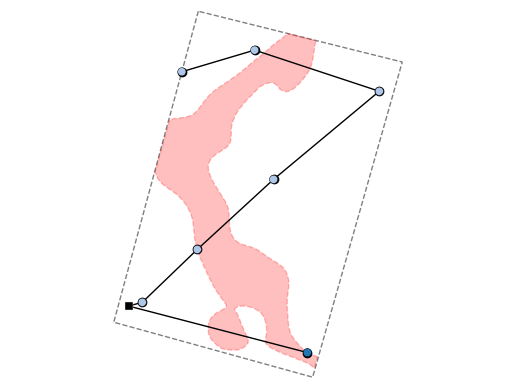

In [6]:
ax = plot_layout(
    prob,
    input_dict=input_dict,
    show_image=False,
    include_cable_routing=True,
)
plt.show()

The result: a farm that fits in a stop-sign domain and minimzes the LCOE.

In [7]:
print(prob.get_val("exclusions.exclusion_distances", units="km"))

[-5.27950257e-01 -1.62553192e-03 -5.95473686e-02 -5.05387198e-01
  1.06862118e-04 -2.62092421e-01 -3.85234167e-01]


In [8]:
print(prob.model.aepFLORIS.fmodel.wind_data.heterogeneous_map)
pp.pprint(prob.model.aepFLORIS.fmodel.core.flow_field.heterogeneous_inflow_config)

HeterogeneousMap with 2 dimensions using interpolation method "linear".
Speed multipliers are defined for 5 points and 3 wind conditions.

         0    1    2    3      4
0.0    1.0  1.0  1.0  1.0  1.125
157.5  1.0  1.0  1.0  1.0  1.125
270.0  1.0  1.0  1.0  1.0  1.125
{'interp_method': 'linear',
 'speed_multipliers': [[1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1.0, 1.0, 1.0, 1.0, 1.125],
                       [1